In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libaries

In [ ]:
# !pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from glob import glob

import numpy as np
import pandas as pd

import cv2
import nibabel as nib

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from matplotlib import animation, cm, rc

# Load data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Xử lý ảnh Y khoa/Project/Data'
TRAIN_PATH = DATA_PATH + '/MICCAI_BraTS2020_TrainingData'
DATA_TYPES = ['t1', 't1ce', 't2', 'flair', 'seg']
MASK_LABELS = ['Not Tumor', 'Non-Enhancing Tumor Core', 'Peritumoral Edema', 'GD-Enhancing Tumor']
MASK_VALUES = [0,1,2,4]

In [ ]:
train_data_paths = {dt: sorted(glob(TRAIN_PATH+'/**/*_{}.nii'.format(dt))) for dt in DATA_TYPES}

# patient id: 355
train_data_paths['seg'].append(TRAIN_PATH+'/BraTS20_Training_355/W39_1998.09.19_Segm.nii')
train_data_paths['seg'] = sorted(train_data_paths['seg'])

for key, vals in train_data_paths.items():
    print('[TRAIN] Number of {} images: {}'.format(key,len(vals)))

[TRAIN] Number of t1 images: 369
[TRAIN] Number of t1ce images: 369
[TRAIN] Number of t2 images: 369
[TRAIN] Number of flair images: 369
[TRAIN] Number of seg images: 369


In [ ]:
data_patient_paths = []
num_image = len(train_data_paths.get('t1'))
for id in range(num_image):
    patient_paths = [train_data_paths[data_type][id] for data_type in DATA_TYPES] # path of each patient's image type
    data_patient_paths.append(patient_paths)

# Survey data

In [ ]:
# Check missing segmentation mask
n_missing = 0
for path in sorted(glob(TRAIN_PATH+'/*')):
    if os.path.isdir(path):
        if not any([f.endswith('seg.nii') or f.endswith('Segm.nii') for f in os.listdir(path)]):
            n_missing+=1
            print(f'Missing segmentation mask for patient: {path.split("/")[-1]}.')
if (n_missing==0): print('No missing segmentation mask for all patients.')

No missing segmentation mask for all patients.


In [ ]:
sample_img = nib.load(data_patient_paths[0][0]).get_fdata()
# sample_img = np.rot90(sample_img)
sample_mask = nib.load(data_patient_paths[0][4]).get_fdata()
# sample_mask = np.rot90(sample_mask)
print("Image shape: ", sample_img.shape)
print("Mask shape: ", sample_mask.shape)

Image shape:  (240, 240, 155)
Mask shape:  (240, 240, 155)


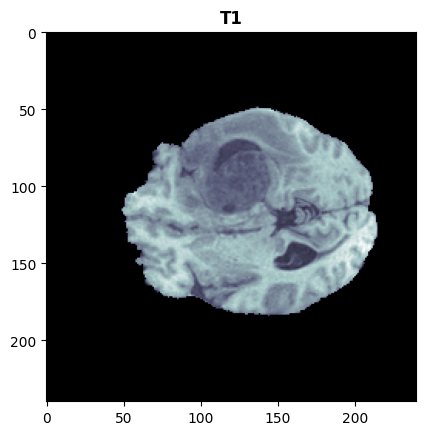

In [ ]:
plt.title('t1'.upper(), weight='bold')
plt.imshow(sample_img[:,:,65], cmap='bone')

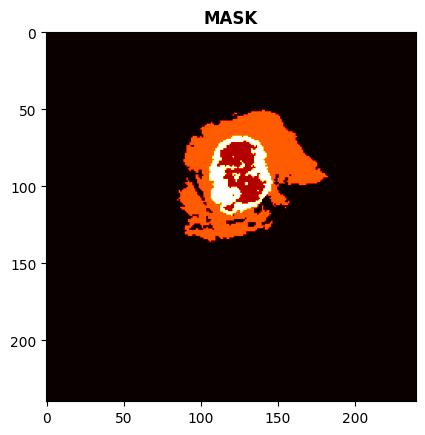

In [ ]:
plt.title('mask'.upper(), weight='bold')
plt.imshow(sample_mask[:,:,65], cmap='hot')

Visualize a few samples

![picture](https://www.frontiersin.org/files/Articles/469332/fncom-13-00058-HTML/image_m/fncom-13-00058-g001.jpg)

In [ ]:
def segment_mask(patient_mask):
    mask_WT = patient_mask.copy() # Whole Tumor - Peritumoral Edema - label 2
    mask_WT[mask_WT == 1] = 1
    mask_WT[mask_WT == 2] = 1
    mask_WT[mask_WT == 4] = 1

    mask_TC = patient_mask.copy() # Tumor Core - N-ET - label 1
    mask_TC[mask_TC == 1] = 1
    mask_TC[mask_TC == 2] = 0
    mask_TC[mask_TC == 4] = 1

    mask_ET = patient_mask.copy() # Enhancing Tumor - label 4 
    mask_ET[mask_ET == 1] = 0
    mask_ET[mask_ET == 2] = 0
    mask_ET[mask_ET == 4] = 1
    return mask_WT, mask_TC, mask_ET
    

def visualize_sample(patient_imgs, id, n_slice=65):
    fig = plt.figure(figsize=(20, 7))
    plt.suptitle('Patient ID: {0:03}'.format(id+1).upper(), fontsize=16, fontweight='bold', y=0.9)
    fig.tight_layout()
    # plt.axis('off')
    for idx, data_type in enumerate(DATA_TYPES[:-1]):
        ax = fig.add_subplot(1,len(DATA_TYPES[:-1])+1,idx+1)
        ax.set_title(data_type.upper(), weight='bold')
        ax.imshow(patient_imgs[idx][:,:,n_slice], cmap='bone')
    
    patient_mask = patient_imgs[-1]
    list_labels = np.unique(patient_mask)[1:]
    idx_lb = [MASK_VALUES.index(l_key) for l_key in list_labels]
    # print('Labels in mask: ',list_labels)
    mask_WT, mask_TC, mask_ET = segment_mask(patient_mask)

    ax5 = fig.add_subplot(155)
    plt.title('mask'.upper(), weight='bold')

    color_masks = ['yellow', 'cyan', 'crimson']
    cmap = [colors.ListedColormap(['darkgray', c]) for c in color_masks]
    bounds=[0,0.5,1]
    norm = [colors.BoundaryNorm(bounds, cm.N) for cm in cmap]
    plt.imshow(patient_imgs[0][:,:,n_slice], cmap="OrRd", alpha=1)
    lb2 = ax5.imshow(mask_WT[:,:,n_slice], cmap=cmap[0], norm=norm[0], alpha=0.65)
    lb1 = ax5.imshow(np.ma.masked_where(mask_TC[:,:,n_slice]==False, mask_TC[:,:,n_slice]), cmap=cmap[1], norm=norm[1], alpha=0.75)
    lb3 = ax5.imshow(np.ma.masked_where(mask_ET[:,:,n_slice]==False, mask_ET[:,:,n_slice]), cmap=cmap[2], norm=norm[2], alpha=0.8)

    c_norm = [im.cmap(im.norm(1)) for im in [lb1,lb2,lb3]]
    patches = [mpatches.Patch(color=c_norm[idx-1], label=f'{MASK_LABELS[idx]}') for idx in idx_lb]
    plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.4, title='Mask Labels', title_fontsize=18, edgecolor='black', facecolor='#c5c6c7')
    return fig

In [ ]:
# from scipy import ndimage
for id in range(281,305): # id = 0,1,2,...368
    patient_imgs = [nib.load(p).get_fdata() for p in data_patient_paths[id]]
    # patient_imgs = [ndimage.rotate(p, -90, axes=(0,1), reshape=False, order=1) for p in patient_imgs] # rotate image 90 degrees

    # plt.subplot(id+1,1,id+1)
    visualize_sample(patient_imgs, id, 70)

Output hidden; open in https://colab.research.google.com to view.